In [35]:
!git clone https://github.com/abhigyan2001/Coded_Aperture

fatal: destination path 'Coded_Aperture' already exists and is not an empty directory.


In [36]:
!cp "/content/Coded_Aperture/load_targets.py" "load_targets.py"

In [37]:
!cp "/content/Coded_Aperture/load_light_field.py" "load_lf.py"

In [38]:
import sys
sys.path.insert(0,'/content/Coded_Aperture')



In [39]:
# Imports 

import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision 
import torchvision.transforms as T
import os 
import random
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import gc
  

In [40]:

# Functions to Load Light Field 

def process_scene(file_path_list):
    img_width = 1024
    img_height = 1024 
    img_stack_size = len(file_path_list)    
    img_stack = np.zeros([3,img_stack_size, img_height, img_width])
    i = 0 


    for file_path in file_path_list:
        
        img = cv2.imread(file_path)
        img = np.asarray(img, dtype= 'float')

        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, : , 2]

        img_stack[0, i, :, :] = r
        img_stack[1, i, :, :] = g 
        img_stack[2, i, :, :] = b 

        i += 1
    return img_stack

def load_lf():
    ## Declaring Constants 
    img_width = 1024
    img_height = 1024


    scene_names = ['BarcaArchVis' , 'Classroom'] #, 'Cupcakes', 'RippleDreams', 'Splash33']


    overall_lf = np.empty(shape= [0, 25, 1024, 1024])
    for scene_name in scene_names:

        directory = "/content/Coded_Aperture"
        range_of_depths = [1, 9, 0.05]

        plane_depth = float(range_of_depths[0])
        max_depth = range_of_depths[1]
        increment = range_of_depths[2]

        directory = os.path.join(directory, f'{scene_name}/Lightfield')
        #print(directory)

        file_path_list = []
        for file in os.listdir(directory):
            if '0' not in  file:
                continue
            file_path_list.append(os.path.join(directory, file))

        lf_stack = process_scene(file_path_list)
        overall_lf = np.append(overall_lf, lf_stack, axis = 0)
        print('loaded lf!')
        print('shape: ', overall_lf.shape)

    return overall_lf



def load_targets():
#if __name__ == "__main__":
    ## Declaring Constants 
    img_width = 1024
    img_height = 1024

    crop_factor = 8


    scene_names = ['BarcaArchVis' , 'Classroom']#, 'Cupcakes', 'RippleDreams', 'Splash33']

    overall_targets = np.empty(shape=[0, 5, 1024, 1024])

    for scene_name in scene_names:

        directory = "/content/Coded_Aperture"
        range_of_depths = [1, 9, 0.05]

        plane_depth = float(range_of_depths[0])
        max_depth = range_of_depths[1]
        increment = range_of_depths[2]

        directory = os.path.join(directory, scene_name)

        file_path_list = []
        plane_depth = 1.00
        while plane_depth <= 3:
            
            img_id = '{:.2f}.png'.format(plane_depth)

            for file in os.listdir(directory):
                if img_id in file:
                  file_path_list.append(os.path.join(directory, file))
                  plane_depth += 0.5
  
        img_stack = process_scene(file_path_list)

        overall_targets = np.append(overall_targets, img_stack, axis=0 )   
        print('loaded targets!')
        print('shape: ', overall_targets.shape) 
    return overall_targets


def load_test_data():
 ## Declaring Constants 
    img_width = 1024
    img_height = 1024


    scene_names = ['Splash33']


    overall_lf = np.empty(shape= [0, 25, 1024, 1024])
    for scene_name in scene_names:

        directory = "/content/Coded_Aperture"
        range_of_depths = [1, 9, 0.05]

        plane_depth = float(range_of_depths[0])
        max_depth = range_of_depths[1]
        increment = range_of_depths[2]

        directory = '/content/Coded_Aperture/Splash/Lightfield'
        #print(directory)

        file_path_list = []
        for file in os.listdir(directory):
            if '0' not in  file:
                continue
            file_path_list.append(os.path.join(directory, file))

        lf_stack = process_scene(file_path_list)
        overall_lf = np.append(overall_lf, lf_stack, axis = 0)
        print('loaded lf!')
        print('shape: ', overall_lf.shape)

    return overall_lf


In [ ]:
lf = load_lf()


In [ ]:
targets = load_targets()

In [ ]:
test = load_test_data()


In [44]:
import torchvision.transforms.functional as f

# Defining Custom Dataset Class
class LF2CADataset(Dataset):
    def __init__(self,lf, targets):
        self.targets= targets
        print('loaded_targets')
        self.lf = lf
        print('loaded Light field')


    def __len__(self):
        return 320

    def __getitem__(self, idx):
        
        idx = random.randint(0,5)

        # Define Probabilities for data augmentation
        intensity = random.uniform(0.5, 1)
        verFlip = random.uniform(0,1)
        horFlip = random.uniform(0, 1)
        
        # Load Image; augment with intensity
        image = self.lf[idx,:, :, :]
        image = image * intensity
        image = torch.tensor(image)

        # Load Targets; augment with intensity 
        target = self.targets[idx, :, :, :]
        target = target * intensity 
        target = torch.tensor(target)

        # Random Vertical Flip
        if verFlip > 0:
          target = f.vflip(target)
          image = f.vflip(image)

        # Random Horizontal Flip
        if horFlip > 0:
          target = f.hflip(target)
          image = f.hflip(image)

        # Random Crop
        cropsize = (128, 128)
        [i, j, h, w] = T.RandomCrop.get_params(
            image, output_size=cropsize)
        image = f.crop(image, i, j, h, w)
        target = f.crop(target, i, j, h, w)

        return image, target


In [ ]:
# Create instance of dataset class 
dataset = LF2CADataset(lf, targets)

# Instantiate a Dataloader
train_dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

In [ ]:
# Code to test the dataset 

fig = plt.figure(figsize=(25,40))
tick = 1
for i in range(10):

  img, target = dataset[0]
  fig.add_subplot(10, 2, tick)
  plt.imshow(img[0,:,:])
  fig.add_subplot(10, 2, tick + 1)
  plt.imshow(target[0,:,:])
  tick += 2

plt.show()


In [ ]:
# Code to visualize the focalstack
sample_fs = targets[2:4, :, :, :]
print(sample_fs.shape)


fig, ax = plt.subplots(2, 5, figsize=(25, 10))
for j in range(sample_fs.shape[0]):
  for i in range(5):

    ax[j,i].imshow(sample_fs[j, i, 500:600, 500:600])

fig.show()


In [ ]:
#Trying to find the MSELoss between two images 
import math
def mse(img1, img2):

  mse = np.square(np.subtract(img1, img2)).sum()
  return mse

img1 = sample_fs[0,0,:,:]
img2 = sample_fs[0, 4, :, :]
print(math.sqrt(mse(img1, img2) / (1024 * 1024))/ 256)





In [49]:

class Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(Block, self).__init__()

        self.skip = torch.nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            torch.nn.BatchNorm2d(out_channels))
        else:
          self.skip = None

        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = x
        out = self.block(x)
        out = out +  identity 
        out = torch.nn.functional.relu(out)
        return out





In [50]:
## Define Model 

def get_cnn_layer(layer_dims, out_dims):

  layer = torch.nn.Sequential(\
          torch.nn.Conv2d(layer_dims, out_dims, kernel_size = 3, padding = 1 ),\
          torch.nn.ReLU(),\
        )
  return layer

class Model(torch.nn.Module):

  def __init__(self, input_dims, output_dims):
    super(Model, self).__init__()
    
    ## Large No of filters in first layer to extract the information, which is followed by successive reduction to transform

    self.layer1 = torch.nn.Conv2d(input_dims, input_dims + 3, kernel_size = 3, padding = 1)
    self.layer2 = torch.nn.Conv2d(input_dims + 3, input_dims + 10, kernel_size = 3, padding = 1)
    self.layer3 = torch.nn.Conv2d(input_dims + 10 ,input_dims + 18, kernel_size = 3, padding = 1)
    self.layer4 = torch.nn.Conv2d(input_dims + 18 , 25, kernel_size = 3, padding = 1)
    self.deep_layers = torch.nn.ModuleList(get_cnn_layer(25, 25) for i in range(10))
    self.resBlocks = torch.nn.ModuleList(Block(25, 25) for i in range(4))
    self.layer_pen = torch.nn.Conv2d(25, 15, kernel_size = 3, padding = 1)
    self.layer_out = torch.nn.Conv2d(15, output_dims, kernel_size = 3, padding = 1)
    

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    #x = self.layer5(x)

    identity = x


    for i, layer in enumerate(self.deep_layers):
      x = layer(x)
  
    x = x + identity

    #for i, block in enumerate(self.resBlocks):
        #x = block(x)
    x = self.layer_pen(x)
    x = self.layer_out(x)
    return x
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lfdims = 25
cap_imgs = 2
focal_stack_size = 5


model = Model(cap_imgs, focal_stack_size )

In [51]:
class CodedAperture(torch.nn.Module):

  def __init__(self, input_dims, output_dims):
    super(CodedAperture, self).__init__()
    self.encode = torch.nn.Conv2d(input_dims, output_dims, kernel_size=1)
  
  def forward(self, x):
    x = self.encode(x)
    return x 






In [ ]:
# Model Initiation sidual


encoder = CodedAperture(lfdims, cap_imgs)
encoder.to(device)
model.to(device)

In [53]:
def calImageGradients(images):
    # x is a 4-D tensor
    dx = images[:, :, :, 1:] - images[:, :, :, :-1]
    dy = images[:, :, 1:, :] - images[:, :, :-1, :]
    return dx, dy

In [54]:
def loss_func(output, target):
  RENORM_SCALE = 0.9

  rmse_intensity = torch.nn.functional.mse_loss(input=output, target=target)
  #print(type(rmse_intensity))
  #print(rmse_intensity.shape)
  psnr_intensity = 20*torch.log10(torch.tensor(RENORM_SCALE)) - 10*torch.log10(rmse_intensity)
   
  labels_dx, labels_dy = calImageGradients(target.clone())
  preds_dx, preds_dy = calImageGradients(output.clone())

  rmse_grad_x, rmse_grad_y =torch.nn.functional.mse_loss(input=labels_dx, target=preds_dx), torch.nn.functional.mse_loss(input=labels_dy, target=preds_dy)
  psnr_grad_x, psnr_grad_y = -20*torch.log10(torch.tensor(RENORM_SCALE)) + 10*torch.log10(rmse_grad_x), -20*torch.log10(torch.tensor(RENORM_SCALE)) + 10*torch.log10(rmse_grad_y)
  loss = -rmse_intensity + 0.5*(psnr_grad_x + psnr_grad_y)
  
  return loss


In [55]:
import torch.optim as optim
learning_rate = 0.014
enc_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [56]:
def Train(epoch, training_losses):
      # Training
    rolling_loss = 0 
    rolling_psnr = 0
    for batch_no, data in enumerate(train_dataloader):
        # Transfer to GPU
        #print(batch_no)
        batch, batch_targets = data
        batch, batch_targets = batch.to(device, torch.float32), batch_targets.to(device, torch.float32)
       
        # Model computations
        #print(batch.shape)
        #print(batch_targets.shape)
        enc_optimizer.zero_grad()
        optimizer.zero_grad()
        
        captured_imgs = encoder(batch)
        predictions = model(captured_imgs)
        #loss = loss_func(predictions, batch_targets)
        loss = criterion(predictions, batch_targets)
        #print(loss)
        #print(predictions.shape, batch_targets.shape)
        loss.backward()
        enc_optimizer.step()
        optimizer.step()

        #Limiting the weights of the filter

        ca = encoder.encode.weight.data

        for j in range(ca.shape[0]):
          for i in range(ca.shape[1]):
            if ca[j,i,:,:] > 1:
              ca[j,i,:,:] = 1
            if ca[j,i,:,:] < 0:
              ca[j,i,:,:] = 0 

        
        rolling_loss += loss.item()
        max = torch.max(predictions)
        print(max)
        rolling_psnr += 10* torch.log10(max * max / loss.item() *len(batch) ) # 10 is batch size
        if batch_no % 1 == 0:
          print('batch_no : ', batch_no)
    avg_rolling_psnr = rolling_psnr / len(batch)
    avg_rolling_loss = rolling_loss /  len(batch)
    
    training_losses.append(avg_rolling_loss)
    print("Epoch: %s, loss: %s, PSNR: %s" % (epoch+1, avg_rolling_loss, avg_rolling_psnr.item()))
    return training_losses
    

In [57]:
ca = encoder.encode.weight.data
print(ca.shape)

torch.Size([2, 25, 1, 1])


In [ ]:
## Training
#torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)
num_epochs = 100

training_losses = []
# Loop over epochs
for epoch in range(num_epochs):
    # Training
    rolling_loss = 0 
    training_losses = Train(epoch, training_losses)
    gc.collect()

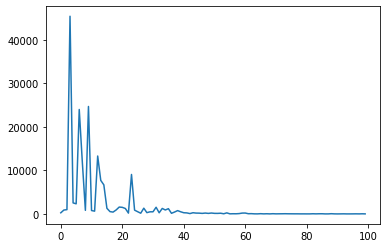

In [59]:
fig= plt.figure()

x = [i for i in range(len(training_losses))]
plt.plot(x, training_losses)

plt.show()

In [ ]:
print(training_losses)

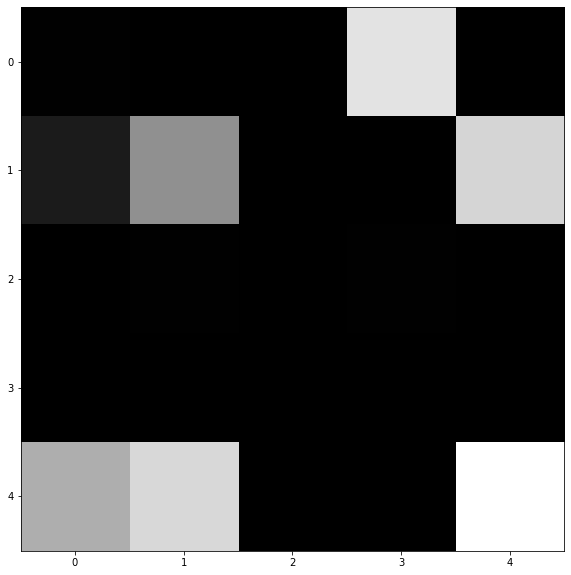

In [61]:
ca = encoder.encode.weight.data

# Code to visualize the Coded Aperture 
from torchvision import utils
layer = 0 
filter = encoder.encode.weight.data.clone()

fig = plt.figure(figsize= (10,10))
rows, cols = 5,5

coded_aperture = np.zeros((rows, cols))
i = 0
for row in range(rows):
  for col in range(cols):

    coded_aperture[row, col] = filter[0,i,:,:]
    i +=1 

plt.imshow(coded_aperture, cmap = 'gray')



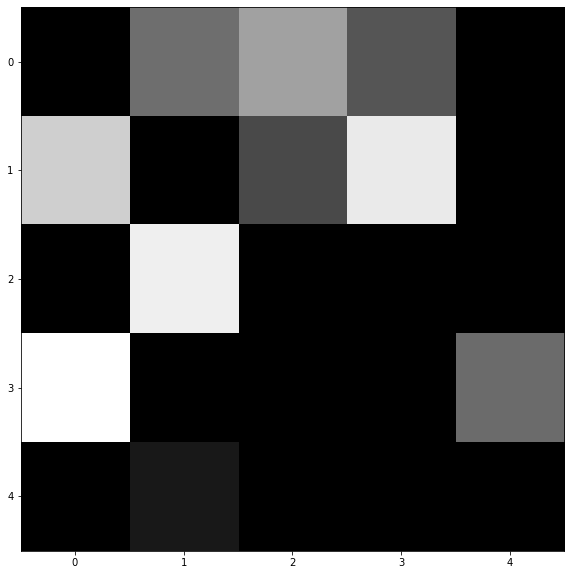

In [62]:
fig = plt.figure(figsize= (10,10))
rows, cols = 5,5

coded_aperture = np.zeros((rows, cols))
i = 0
for row in range(rows):
  for col in range(cols):

    coded_aperture[row, col] = filter[1,i,:,:]
    i +=1 

plt.imshow(coded_aperture, cmap = 'gray')

In [ ]:
print(coded_aperture)

torch.Size([1, 5, 1024, 1024])
torch.Size([1, 5, 1024, 1024])
torch.Size([1, 5, 1024, 1024])


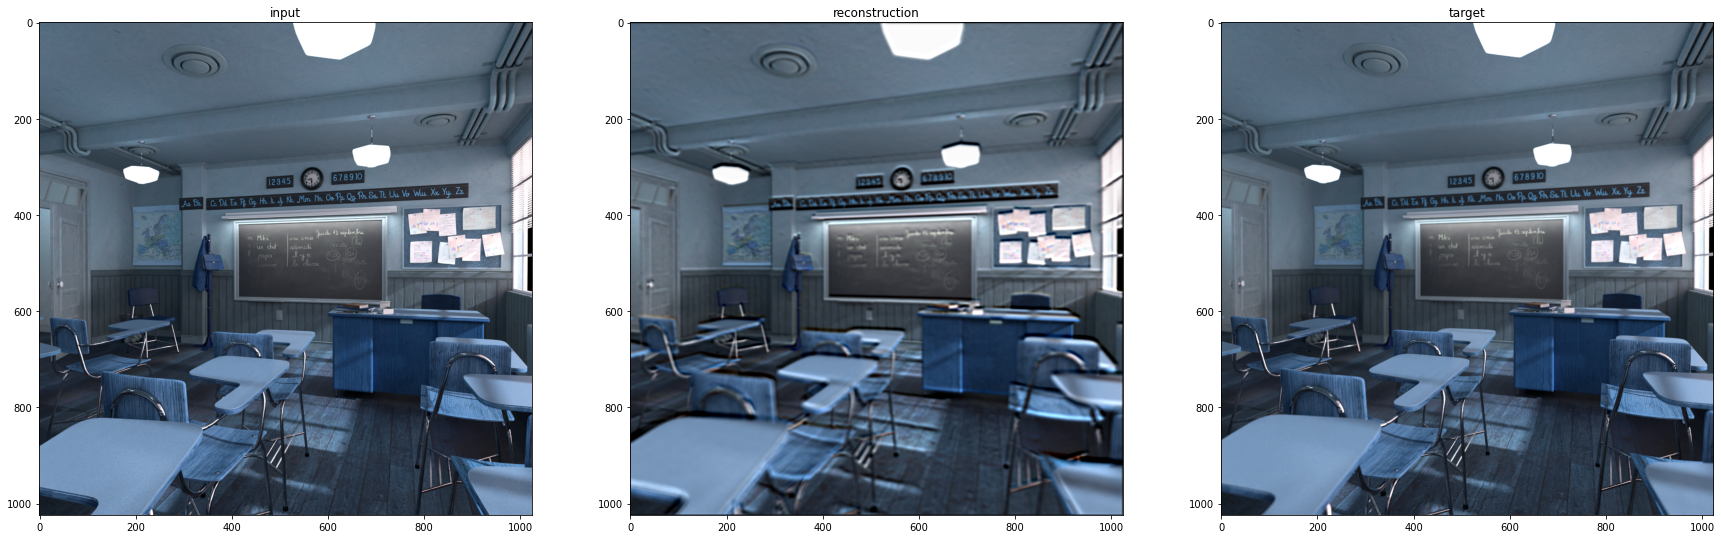

In [64]:
num_scenes = 2
num_channels = 3
i = 1

r_channel_lf = lf[num_channels * i, :, :, :]
g_channel_lf = lf[num_channels * i + 1, :, :, :]
b_channel_lf = lf[num_channels * i + 2, :, :, :]


r_channel_targets = targets[num_channels * i, :, :, :]
g_channel_targets = targets[num_channels * i + 1, :, :, :]
b_channel_targets = targets[num_channels * i + 2, :, :, :]

#Choosing the centre view

# Selecting slice for inputs
sample_input = np.zeros(shape=(1024,1024,3))
sample_input[:,:,0] = r_channel_lf[13,:,:]
sample_input[:,:,1] = g_channel_lf[13,:,:]
sample_input[:,:,2] = b_channel_lf[13,:,:]

#Selecting slice for targets
sample_target = np.zeros(shape=(1024,1024,3))
sample_target[:,:,0] = r_channel_targets[2,:,:]
sample_target[:,:,1] = g_channel_targets[2,:,:]
sample_target[:,:,2] = b_channel_targets[2,:,:]

r_channel_lf = torch.tensor(r_channel_lf, dtype=torch.float32)
g_channel_lf = torch.tensor(g_channel_lf, dtype=torch.float32)
b_channel_lf = torch.tensor(b_channel_lf, dtype=torch.float32)

r_channel_lf = r_channel_lf.to(device)
g_channel_lf = g_channel_lf.to(device)
b_channel_lf = b_channel_lf.to(device)                                    

r_channel_cap = encoder(r_channel_lf)
g_channel_cap = encoder(g_channel_lf)
b_channel_cap = encoder(b_channel_lf)                              

r_preds = model(r_channel_cap[None, :, :, :])
g_preds = model(g_channel_cap[None, :, :, :])
b_preds = model(b_channel_cap[None, :, :, :])

print(r_preds.shape)
print(g_preds.shape)
print(b_preds.shape)


# Taking a slice of the image
r_preds = r_preds.cpu().detach().numpy()
g_preds = g_preds.cpu().detach().numpy()
b_preds = b_preds.cpu().detach().numpy()


sample_pred = np.zeros((1024, 1024, 3))
sample_pred[:,:,0] = r_preds[0,2,:,:]
sample_pred[:,:,1] = g_preds[0,2,:,:]
sample_pred[:,:,2] = b_preds[0,2,:,:]

#Plot the reconstructed lf for a single slice 
rows, cols = 1,3
fig = plt.figure(figsize=(30, 10))

plt.subplot(rows, cols, 1)
plt.imshow(sample_input.astype(int))
plt.title('input')

plt.subplot(rows, cols, 2)
plt.imshow(sample_pred.astype(int))
plt.title('reconstruction')

plt.subplot(rows, cols, 3)
plt.imshow(sample_target.astype(int))
plt.title('target')
plt.show()




torch.Size([2, 1024, 1024])
torch.Size([1, 5, 1024, 1024])
torch.Size([1, 5, 1024, 1024])
torch.Size([1, 5, 1024, 1024])


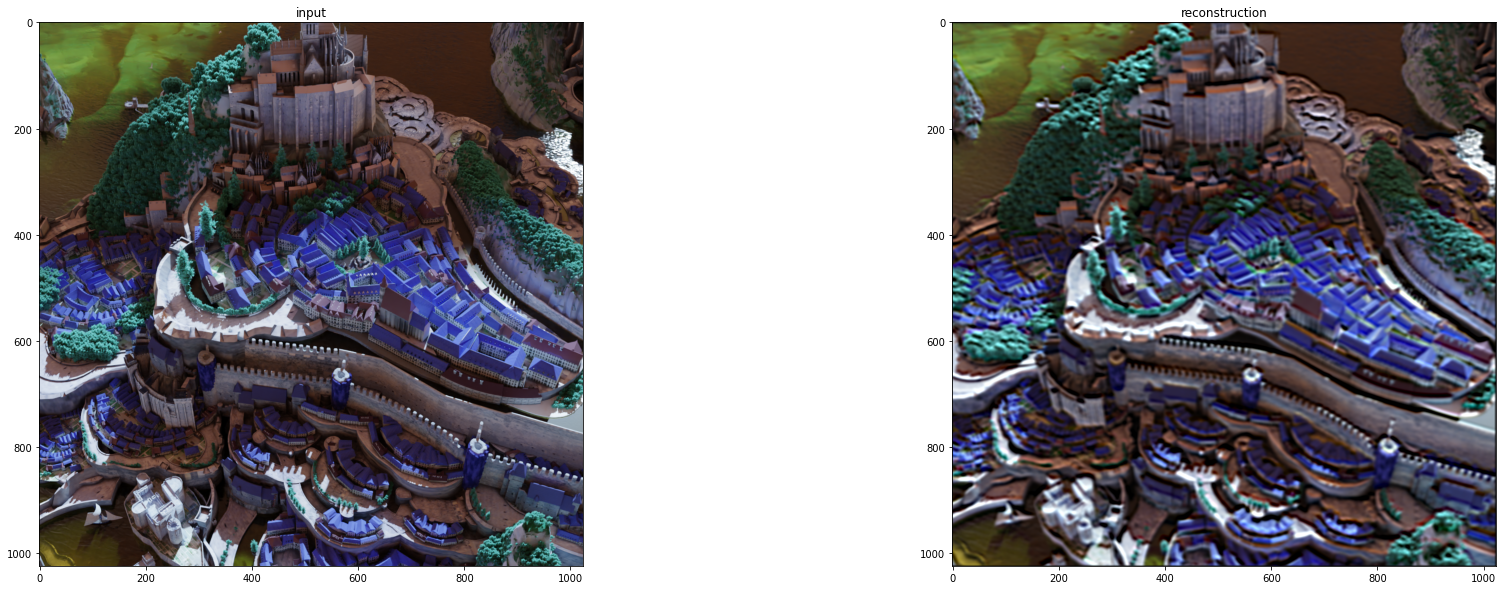

In [65]:
num_scenes = 2
num_channels = 0
i = 1

r_channel_lf = test[num_channels * i, :, :, :]
g_channel_lf = test[num_channels * i + 1, :, :, :]
b_channel_lf = test[num_channels * i + 2, :, :, :]



#Choosing the centre view

# Selecting slice for inputs
sample_input = np.zeros(shape=(1024,1024,3))
sample_input[:,:,0] = r_channel_lf[13,:,:]
sample_input[:,:,1] = g_channel_lf[13,:,:]
sample_input[:,:,2] = b_channel_lf[13,:,:]


r_channel_lf = torch.tensor(r_channel_lf, dtype=torch.float32)
g_channel_lf = torch.tensor(g_channel_lf, dtype=torch.float32)
b_channel_lf = torch.tensor(b_channel_lf, dtype=torch.float32)

r_channel_lf = r_channel_lf.to(device)
g_channel_lf = g_channel_lf.to(device)
b_channel_lf = b_channel_lf.to(device)                                    

r_channel_cap = encoder(r_channel_lf)
g_channel_cap = encoder(g_channel_lf)
b_channel_cap = encoder(b_channel_lf)                                    

print(r_channel_cap.shape)
r_preds = model(r_channel_cap[None, :, :, :])
g_preds = model(g_channel_cap[None, :, :, :])
b_preds = model(b_channel_cap[None, :, :, :])


print(r_preds.shape)
print(g_preds.shape)
print(b_preds.shape)


# Taking a slice of the image
r_preds = r_preds.cpu().detach().numpy()
g_preds = g_preds.cpu().detach().numpy()
b_preds = b_preds.cpu().detach().numpy()


sample_pred = np.zeros((1024, 1024, 3))
sample_pred[:,:,0] = r_preds[0,2,:,:]
sample_pred[:,:,1] = g_preds[0, 2,:,:]
sample_pred[:,:,2] = b_preds[0, 2,:,:]

#Plot the reconstructed lf for a single slice 
rows, cols = 1,2
fig = plt.figure(figsize=(30, 10))

plt.subplot(rows, cols, 1)
plt.imshow(sample_input.astype(int))
plt.title('input')

plt.subplot(rows, cols, 2)
plt.imshow(sample_pred.astype(int))
plt.title('reconstruction')

plt.show()




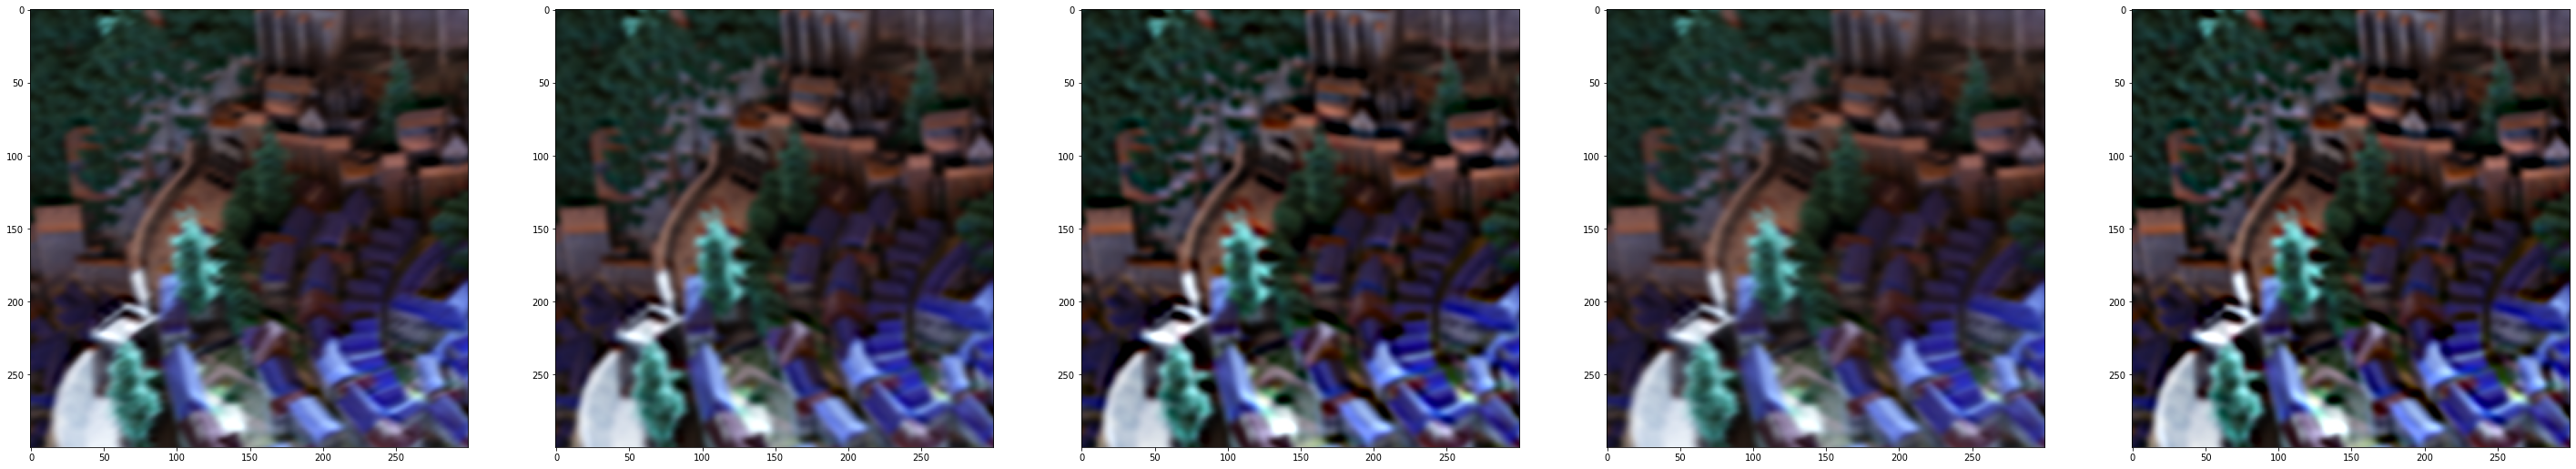

In [71]:
#Code to display focal stack
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(50,10))

for i in range(5):
  img = np.zeros((300, 300, 3))
  img[:,:,0] = r_preds[0,i, 200:500,200:500]
  img[:,:,1] = g_preds[0, i, 200:500,200:500]
  img[:,:,2] = b_preds[0,i, 200:500,200:500]
  
  #print(img)
  axes[i].imshow(img.astype(int))



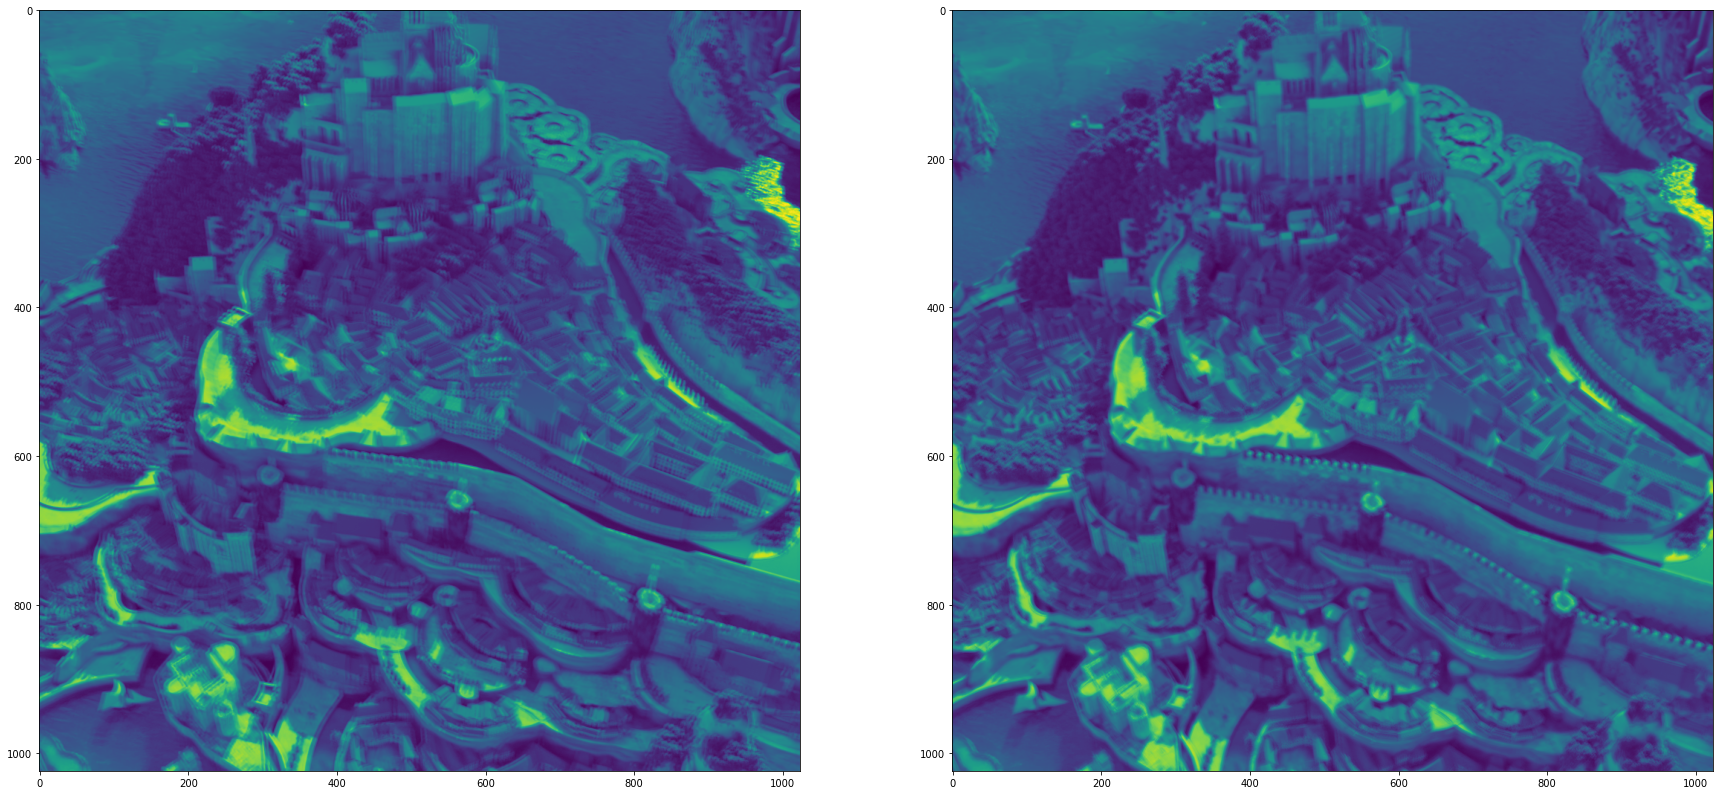

In [67]:
enc1 = r_channel_cap[0,:,:].cpu().detach().numpy()
enc2 = r_channel_cap[1,:,:].cpu().detach().numpy()

fig, ax = plt.subplots(1, 2, figsize = (30,15))

ax[0].imshow(enc1)
ax[1].imshow(enc2)



In [68]:
print(math.sqrt(mse(enc1, enc2) / (1024 * 1024))/ 256)


0.14646778648544628
